# Sidekick - Mixture of Least Squares
We train a mixture of least squares, experimenting with different number of components.

In [1]:
%matplotlib inline
from __future__ import print_function
import os
import sys
sys.path.insert(0, os.path.abspath('../utils/')) # Add sibling to Python path
sys.path.insert(0, os.path.abspath('../src/')) # Add sibling to Python path
sys.stdout.flush() # Print output on the fly in Notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16,14)
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['legend.fontsize'] = 16
from IPython.display import display
import numpy as np
import pickle as cp
import matplotlib.pyplot as plt
from dataset import Sidekick
from model import LeastSquaresMixture
from math import floor

DATA_DIR = "../data/sidekick"

def subsample(t0, t1, n_samples):
    t = t1 - t0
    if n_samples >= t:
        return range(t0, t1)
    samples = range(t0, t1, int(np.ceil(t / float(n_samples))))
    return samples

## Load and split data

In [2]:
sk = Sidekick()
sk.load()
projects_train, projects_test = sk.split(threshold=0.7)
total = len(projects_train) + len(projects_test)

Loading data set...
Data loaded.


### Visualize projects at different times

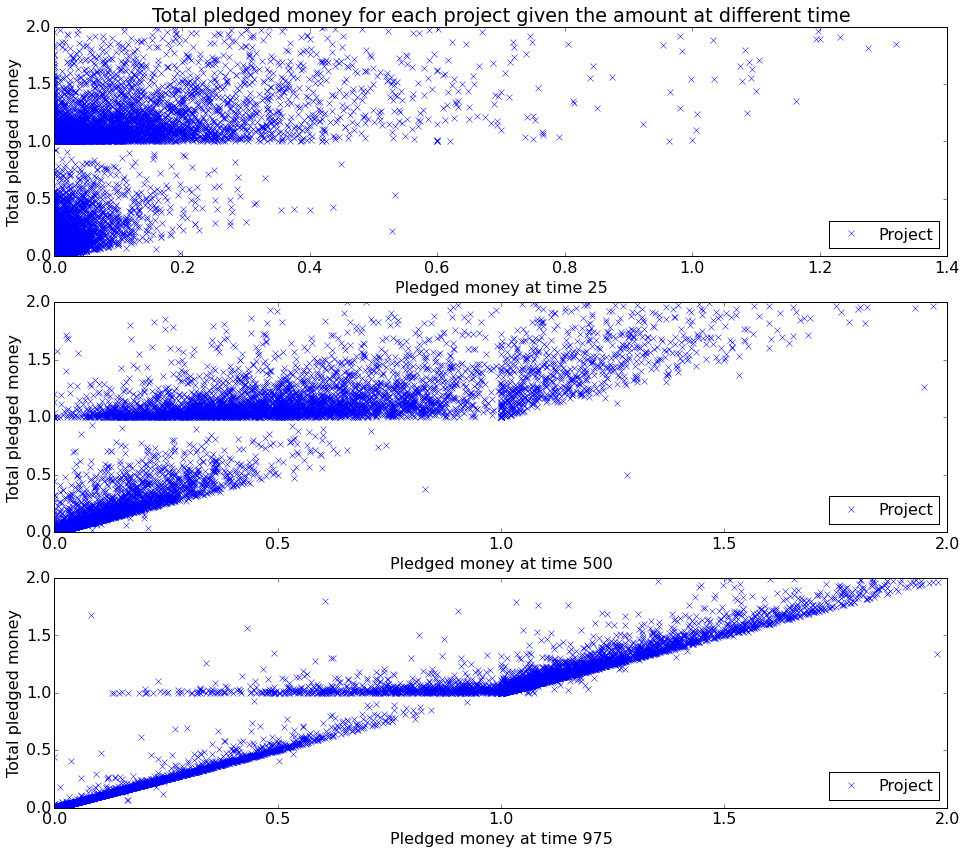

In [17]:
T = 999

plt.figure(2)
outlier_threshold = 2

plt.subplot(311)
t = 25
yt = [p.money[t] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
yT = [p.money[T] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
plt.plot(yt, yT, 'x')
plt.xlabel('Pledged money at time %s' % t)
plt.ylabel('Total pledged money')
plt.legend(['Project'], loc=4, numpoints=1)
plt.title('Total pledged money for each project given the amount at different time')

plt.subplot(312)
t = 500
yt = [p.money[t] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
yT = [p.money[T] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
plt.plot(yt, yT, 'x')
plt.xlabel('Pledged money at time %s' % t)
plt.ylabel('Total pledged money')
plt.legend(['Project'], loc=4, numpoints=1)

plt.subplot(313)
t = 975
yt = [p.money[t] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
yT = [p.money[T] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
plt.plot(yt, yT, 'x')
plt.xlabel('Pledged money at time %s' % t)
plt.ylabel('Total pledged money')
plt.legend(['Project'], loc=4, numpoints=1)


plt.savefig('final_money_vs_pledged_money.pdf')
plt.show()

## Data processing

In [36]:
#N = 16000
#N_train = int(floor(0.8*N))
seed = 2
t0 = 1
t1 = 25
n_samples = 1
T = 999

samples = subsample(t0, t1, n_samples)
t = len(samples)
samples = t1 - 1

#N_projects = sk.choose_n_projects(n=N, seed=seed)
#projects_train = N_projects[:N_train]
#projects_test = N_projects[N_train:]

# Remove outliers
outlier_threshold = 2  # Ignore the project whose total pledged money if more that o_t times their goal
projects_train_filtered = [p for p in projects_train if p.money[T] < outlier_threshold and p.money[samples] < outlier_threshold]
projects_test_filtered = [p for p in projects_test if p.money[T] < outlier_threshold and p.money[samples] < outlier_threshold]
#projects_test_filtered = projects_test

X_train = np.ndarray(shape=(len(projects_train_filtered), t), buffer=np.array([p.money[samples] for p in projects_train_filtered]), dtype=float) 
y_train = np.expand_dims(np.array([p.money[T] for p in projects_train_filtered]), axis=1)
X_test = np.ndarray(shape=(len(projects_test_filtered), t), buffer=np.array([p.money[samples] for p in projects_test_filtered]), dtype=float) 
y_test = np.expand_dims(np.array([p.money[T] for p in projects_test_filtered]), axis=1)

# Required to contain the prediction in a reasonable range
# The problem arises when evaluating the likelihood in the expression for gamma_nk
#X_max = np.max(X_train, axis=0)
#X_train = X_train / X_max[np.newaxis, :]
# Apply same preprocessing to testing set
#X_test = X_test / X_max[np.newaxis, :]  

total_filtered = len(X_train) + len(X_test)
print("Removed %0.2f%% outliers" % (100 - total_filtered / total * 100))
print("Training on %s projects (%0.2f%%)" % (len(X_train), len(X_train) / total_filtered * 100))
print("Testing on %s projects (%0.2f%%)" % (len(X_test), len(X_test) / total_filtered * 100))
print("Number of features: %s" % n_samples)

Removed 7.15% outliers
Training on 10341 projects (70.05%)
Testing on 4422 projects (29.95%)
Number of features: 1


## Training

### Simple Training

In [42]:
K = 2
beta = 1 / np.var(y_train)
epsilon = 1
lam = 0
iterations = 1000
random_restarts = None

mls1 = LeastSquaresMixture(X_train, y_train, 
                          K=K, beta=beta, lam=lam, 
                          iterations=iterations, epsilon=epsilon, random_restarts=random_restarts)
#mls1.train(verbose=True)
mls1.w[0, 0] = 0.04254392
mls1.w[1, 0] = 2.62458562
mls1.pi[0] = 0.5
#mls1.beta[0] = 86.3519133
mls1.w[0, 1] = 1.12565788
mls1.w[1, 1] = 0.54935766
mls1.pi[1] = 0.5
#mls1.beta[1] = 2.44219068e+01
mls1.trained = True

print(mls1)

Model:        LeastSquaresMixture (2 components)
Likelihood:   -inf
Beta:         [ 3.07836676  3.07836676]
Lambda:       0
Pi:           [ 0.5  0.5]
Weights norm: [2.624930410856591, 1.2525571848848938]
[[ 0.04254392  1.12565788]
 [ 2.62458562  0.54935766]]


In [21]:
K = 2
beta = 1 / np.var(y_train)
#beta = 0.0001
epsilon = 1e0
lam = 0
iterations = 1000
random_restarts = 10

mls2 = LeastSquaresMixture(X_train, y_train, 
                          K=K, beta=beta, lam=lam, 
                          iterations=iterations, epsilon=epsilon, random_restarts=random_restarts)
mls2.train(verbose=False)

print(mls2)

Random restarts (10/10): [####################] 100% Elapsed time: 0:00:16
Model:        LeastSquaresMixture (2 components)
Likelihood:   9680.04455294976
Beta:         [ 86.3519133    9.13126013]
Lambda:       0
Pi:           [ 0.90436786  0.09563214]
Weights norm: [2.6249304080290115, 0.6096126515424064]
[[ 0.04254392  0.39942553]
 [ 2.62458562  0.46052886]]


In [27]:
K = 2
beta = 1 / np.var(y_train)
#beta = 0.0001
epsilon = 1e0
lam = 0
iterations = 1000
random_restarts = 10

mls3 = LeastSquaresMixture(X_train, y_train, 
                          K=K, beta=beta, lam=lam, 
                          iterations=iterations, epsilon=epsilon, random_restarts=random_restarts)
mls3.train(verbose=False)

print(mls3)

Random restarts (10/10): [####################] 100% Elapsed time: 0:00:06
Model:        LeastSquaresMixture (2 components)
Likelihood:   4992.522764397649
Beta:         [  8.46937366e-13   2.44219068e+01]
Lambda:       0
Pi:           [  3.46794120e-14   1.00000000e+00]
Weights norm: [1.9381693203083667, 1.2525571860491151]
[[ 1.88926682  1.12565788]
 [-0.43263287  0.54935766]]


### Display weights

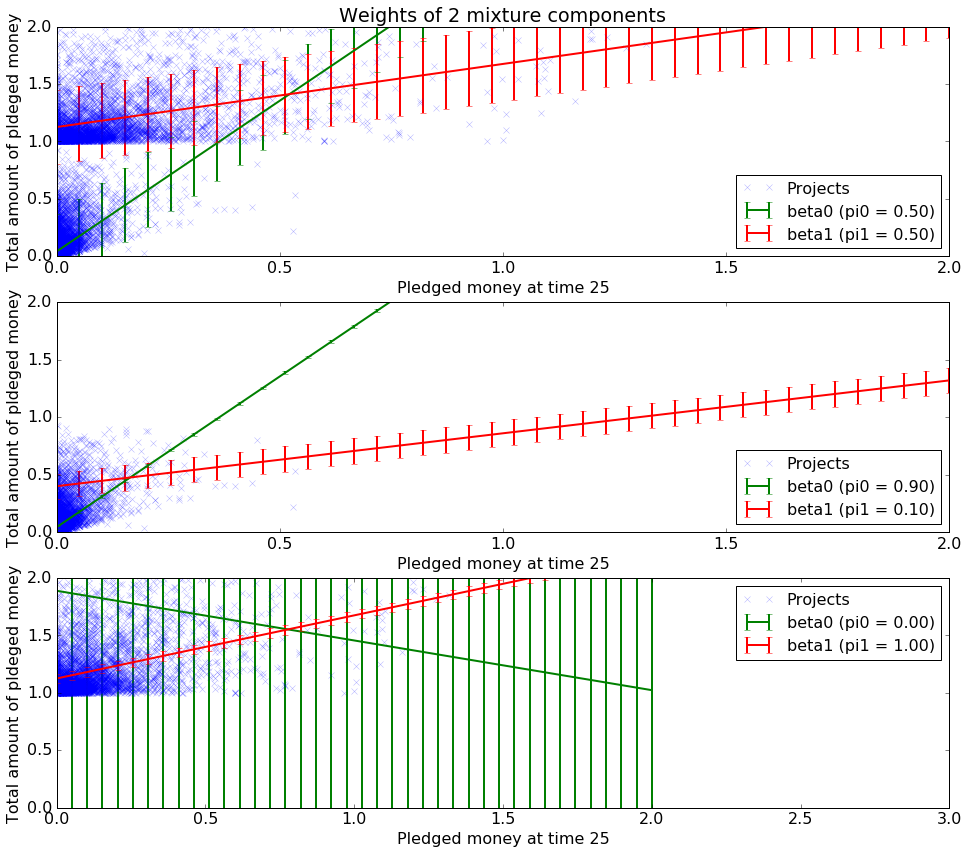

In [43]:
projects = True
n_points = 40
K = 2

x = np.ones((n_points, 2))
x[:, 1] = np.linspace(0, outlier_threshold, n_points)

y1 = []
for k in range(K):
    w_k = mls1.w[:, k]
    y1.append(x.dot(w_k))

y2 = []
for k in range(K):
    w_k = mls2.w[:, k]
    y2.append(x.dot(w_k))

y3 = []
for k in range(K):
    w_k = mls3.w[:, k]
    y3.append(x.dot(w_k))

plt.figure(1)

plt.subplot(311)
t = 25
if projects:
    yt = [p.money[t] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
    yT = [p.money[T] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
    plt.plot(yt, yT, 'x', label="Projects", alpha=0.3)
for k in range(K):
    plt.errorbar(x[:, 1], y1[k], x[:, 0] / mls1.beta[k], label="beta%s (pi%s = %0.2f)" % (k, k, mls1.pi[k],), lw=2)
plt.title("Weights of %s mixture components" % K)
plt.xlabel("Pledged money at time %s" % t)
plt.ylabel("Total amount of pldeged money")
plt.xlim([0, 2])
plt.ylim([0, 2])
plt.legend(loc='best')

plt.subplot(312)
t = 25
if projects:
    yt = [p.money[t] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold and not p.successful]
    yT = [p.money[T] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold and not p.successful]
    plt.plot(yt, yT, 'x', label="Projects", alpha=0.3)
for k in range(K):
    plt.errorbar(x[:, 1], y2[k], x[:, 0] / mls2.beta[k], label="beta%s (pi%s = %0.2f)" % (k, k, mls2.pi[k],), lw=2)
plt.xlabel("Pledged money at time %s" % t)
plt.ylabel("Total amount of pldeged money")
plt.xlim([0, 2])
plt.ylim([0, 2])
plt.legend(loc='best')

plt.subplot(313)
t = 25
if projects:
    yt = [p.money[t] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold and p.successful]
    yT = [p.money[T] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold and p.successful]
    plt.plot(yt, yT, 'x', label="Projects", alpha=0.3)
for k in range(K):
    plt.errorbar(x[:, 1], y3[k], x[:, 0] / mls3.beta[k], label="beta%s (pi%s = %0.2f)" % (k, k, mls3.pi[k],), lw=2)
plt.xlabel("Pledged money at time %s" % t)
plt.ylabel("Total amount of pldeged money")
plt.xlim([0, 3])
plt.ylim([0, 2])
plt.legend(loc='best')

plt.savefig("weights.pdf")
plt.show()

## Testing

### Full Test Set

In [44]:
rmse_failed, rmse_success, rmse, accuracy = mls1.evaluate(X_test, y_test, verbose=True)

Evaluating model LeastSquaresMixture (2 components)...
Data point (4422/4422): [####################] 100% Elapsed time: 0:00:01
Accuracy     : 0.6322930800542741
RMSE         : 0.499434248293
RMSE failed  : 0.519249394068
RMSE success : 0.472160987771


In [35]:
rmse_failed, rmse_success, rmse, accuracy = mls2.evaluate(X_test, y_test, verbose=True)

Evaluating model LeastSquaresMixture (2 components)...
Data point (2510/2510): [####################] 100% Elapsed time: 0:00:01
Accuracy     : 0.999601593625498
RMSE         : 0.135364880809
RMSE failed  : 0.135364880809
RMSE success : nan


/Users/victorkristof/.virtualenvs/gp3/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/victorkristof/.virtualenvs/gp3/lib/python3.4/site-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [32]:
rmse_failed, rmse_success, rmse, accuracy = mls3.evaluate(X_test, y_test, verbose=True)

Evaluating model LeastSquaresMixture (2 components)...
Data point (1912/1912): [####################] 100% Elapsed time: 0:00:01
Accuracy     : 1.0
RMSE         : 0.199233611039
RMSE failed  : nan
RMSE success : 0.199233611039


/Users/victorkristof/.virtualenvs/gp3/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/victorkristof/.virtualenvs/gp3/lib/python3.4/site-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Single Point

In [15]:
test = 12
x_new = X_test[test]
y_new = mls3.predict(x_new, posteriors=True)
y_true = y_test[test]
print("Predicted:  %s" % y_new)
#print("Posteriors: %s" % ["%0.2f%%" % (p * 100) for p in y_posteriors])
print("Actual:     %s" % y_true)

Predicted:  0.844715677913
Actual:     [ 1.02310255]


### Predictive Distribution

Predicted: 0.64599279396
Actual: 0.283377793978
pi_k: [ 0.5  0.5]


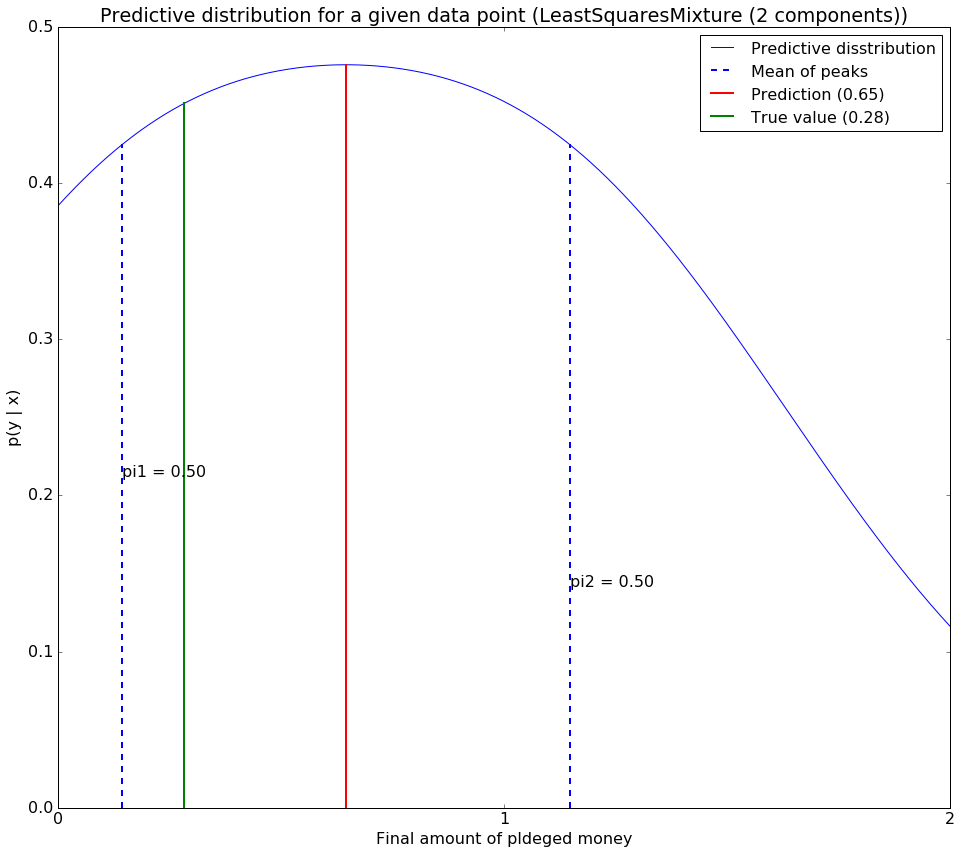

In [48]:
def predictive_distribution(mls, x, y):
    p = 0
    for k in range(mls.K):
        pi_k = mls.pi[k]
        beta_k = mls.beta[k]
        w_k = mls.w[:, k]
        p += pi_k * np.sqrt(beta_k / (2 * np.pi)) * np.exp(- beta_k / 2 * (y - np.dot(tx, w_k))**2)
    return p

mls = mls1

test = 2
outlier_threshold = 2
x_new = X_test[test]
y_new = mls.predict(x_new, posteriors=True)
y_true = y_test[test]

tx = np.ones((1, len(x_new ) + 1))
tx[0, 1:] = x_new
y = np.linspace(0, outlier_threshold, 1000)
py = predictive_distribution(mls, tx, y)

print("Predicted:", y_new)
print("Actual:", y_true[0])
print("pi_k:", mls.pi)

m1 = np.dot(tx, mls.w[:, 0])[0]
beta1 = mls.beta[0]
pi1 = mls.pi[0]
m2 = np.dot(tx, mls.w[:, 1])[0]
beta2 = mls.beta[1]
pi2 = mls.pi[1]

plt.figure()
plt.plot(y, py, label="Predictive disstribution")
plt.plot((m1, m1), (0, predictive_distribution(mls, tx, m1)), 'b--', lw=2)
plt.plot((m2, m2), (0, predictive_distribution(mls, tx, m2)), 'b--', lw=2, label="Mean of peaks")
plt.plot((y_new, y_new), (0, predictive_distribution(mls, tx, y_new)), 'r', lw=2, label="Prediction (%0.2f)" % y_new)
plt.plot((y_true, y_true), (0, predictive_distribution(mls, tx, y_true)), 'g', lw=2, label="True value (%0.2f)" % y_true)
plt.text(m1, predictive_distribution(mls, tx, m1) / 2, "pi1 = %0.2f" % mls.pi[0])
plt.text(m2, predictive_distribution(mls, tx, m2) / 3, "pi2 = %0.2f" % mls.pi[1])
plt.xticks(np.arange(min(y), max(y)+1, 1.0))
plt.title("Predictive distribution for a given data point (%s)" % mls.name)
plt.xlabel("Final amount of pldeged money")
plt.ylabel("p(y | x)")
plt.legend(loc=1)
plt.savefig("predictive_distribution.pdf")
plt.show()

### Grid Search Training

In [ ]:
K = 3
epsilon = 1e-2
iterations = 1000
random_restarts = 10
betas = np.array([1/np.var(y_train)])
lambdas = np.logspace(-8, 2, 50)
lambdas = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
k_fold = 2

mls = LeastSquaresMixture(X_train, y_train, K=K,
                          iterations=iterations, epsilon=epsilon, random_restarts=random_restarts)
rmse_avg, rmse_std, accuracy_avg, accuracy_std = mls.grid_search(betas, lambdas, k_fold=k_fold)

print(mls)